# CYP21A2
The CYP21A2 gene encodes the 21-hydroxylase enzyme (EC 1.14.99.10), which is essential for adrenal steroidogenesis.
[Congenital adrenal hyperplasia](https://omim.org/entry/201910) is caused by homozygous or compound heterozygous mutation in the CYP21A2 gene.
In about 95% of cases, 21-hydroxylation is impaired in the zona fasciculata of the adrenal cortex so that 17-hydroxyprogesterone (17-OHP) is not converted to 11-deoxycortisol.

This notebook analyzes data curated from [Xu C, et al. (2019) Genotype-phenotype correlation study and mutational and hormonal analysis in a Chinese cohort with 21-hydroxylase deficiency. Mol Genet Genomic Med](https://pubmed.ncbi.nlm.nih.gov/30968594/). 

We will follow the authors with the
> assumption that the mildest mutation determines the phenotype in compound heterozygotes.

The authors measured Residual activity of the different mutant proteins in COS7 cells (See Figure 3). The variants with the highest residual activities were
I73N, V282L, P454S, and P483S (between 9.5-8%). One tested missense variant, H393Q, had a lower residual activity (2.2%). 

We will therefore use the CohortVariantViewer to show a table with all variants in the cohort and compare the missense variants with the rest with respect to
correlations with 17-OHP level. Note that not all missesne variants were tested, so we will also perform a test with just I73N, V282L, P454S, and P483S.


In [3]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.9.1.dev0


# CYP21A2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for CYP21A2.

In [4]:
gene_symbol = 'CYP21A2'
mane_tx_id = 'NM_000500.9'
mane_protein_id = 'NP_000491.4' # steroid 21-hydroxylase isoform a [Homo sapiens]

In [6]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.22") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
len(phenopackets)


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()


Individuals Processed: 100%|██████████| 69/69 [01:35<00:00,  1.39s/individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
viewer = CohortViewer(hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
47,Increased circulating prolactin concentration
43,Increased circulating ACTH level
41,Hyperpigmentation of the skin
26,Clitoral hypertrophy
23,Decreased serum testosterone concentration
23,Decreased circulating cortisol level
18,Increased serum testosterone level
18,Decreased serum estradiol
4,Hirsutism
4,Diarrhea


In [5]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
35,6_32039081_32039081_C_G,c.293-13C>G (-),-,"splice polypyrimidine, intronic"
25,SO:1000029_HGNC:2600_CYP21A2,SV involving CYP21A2 (p.?),,chromosomal deletion
18,6_32039426_32039426_T_A,c.518T>A (p.Ile173Asn),4,missense
13,6_32040421_32040421_C_T,c.955C>T (p.Gln319Ter),8,stop gained
5,6_32040535_32040535_C_T,c.1069C>T (p.Arg357Trp),8,missense
3,6_32040072_32040072_G_C,c.806G>C (p.Ser269Thr),7,missense
3,6_32038514_32038514_C_T,c.92C>T (p.Pro31Leu),1,missense
3,6_32040182_32040182_G_GT,c.923dup (p.Leu308PhefsTer6),7,frameshift
3,6_32039132_32039140_GGAGACTAC_G,c.332_339del (p.Gly111ValfsTer21),3,frameshift
2,SO:1000037_HGNC:2600_CYP21A2,SV involving CYP21A2 (p.?),,chromosomal duplication


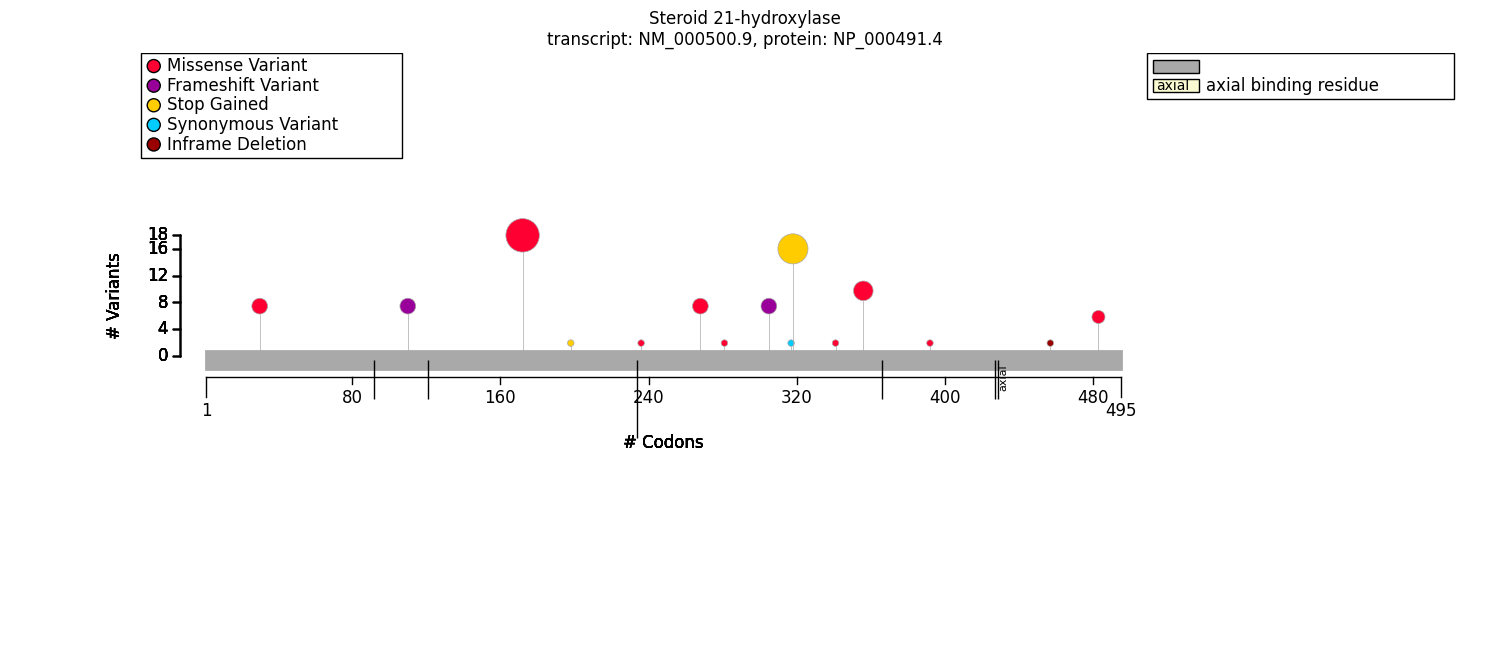

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service
from gpsea.view import ProteinVisualizable, ProteinVisualizer
import matplotlib.pyplot as plt


txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)



cyp21a2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
cyp21a2_fig.tight_layout()

# Strategy
We will investigate whether a correlation can be found with variants associated with the salt-wasting phenotype (see above).
Recall the codes for [partitioning autosomal recessive variants](https://monarch-initiative.github.io/gpsea/stable/user-guide/predicates/mode_of_inheritance_predicate.html)
- No allele 0
- Monoallelic 1
- Biallelic 2

Therefore, for the following code:

```python
missense_predicate = biallelic_predicate(
    a_predicate=is_missense,
    b_predicate=i2g_variant,
    names=( "I2G", "missense"),
    partitions=((0,), (1,2,))
)
```
We are comparing the genotype of no missense alleles (0) vs. one missense/one I2G (1) or two missense (2)


In [7]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.model import VariantEffect

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

two_missense_predicate = biallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="other",
    b_label= "missense",
    partitions=((0,), (1,2))
)

one_or_two_missense_predicate = biallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="other",
    b_label= "missense",
    partitions=((0,1), (2,))
)


#  

In [8]:
from gpsea.analysis.pscore import MeasurementPhenotypeScorer, PhenotypeScoreAnalysisResult
from gpsea.analysis.pscore.stats import TTestStatistic
from gpsea.analysis.pscore import PhenotypeScoreAnalysis
from gpsea.analysis.clf import GenotypeClassifier
from gpsea.model import Cohort

def perform_t_test(loinc_id: str,
                   loinc_label: str,
                   cohort: Cohort,
                   gt_predicate: GenotypeClassifier) -> PhenotypeScoreAnalysisResult:
    pheno_scorer = MeasurementPhenotypeScorer.from_measurement_id( term_id=loinc_id,label=loinc_label )
    score_statistic = TTestStatistic()
    score_analysis = PhenotypeScoreAnalysis(
        score_statistic=score_statistic,
    )
    result = score_analysis.compare_genotype_vs_phenotype_score(
        cohort=cohort,
        gt_clf=gt_predicate,
        pheno_scorer=pheno_scorer,
    )
    return result

# 17-Hydroxyprogesterone
We use the LOINC code for "17-Hydroxyprogesterone [Mass/volume] in Serum or Plasma", [LOINC:1668-3](https://loinc.org/1668-3).

In [9]:
loinc_id ="LOINC:1668-3"
loinc_label = "17-Hydroxyprogesterone [Mass/volume] in Serum or Plasma"
result_1_or_2_missense_17hp = perform_t_test(loinc_id=loinc_id, loinc_label=loinc_label, cohort=cohort, gt_predicate=one_or_two_missense_predicate)
print(f"missense (1 or 2): t test for {loinc_label}({loinc_id}): {result_1_or_2_missense_17hp.pval}")
result_2_missense_17hp = perform_t_test(loinc_id=loinc_id, loinc_label=loinc_label, cohort=cohort, gt_predicate=two_missense_predicate)
print(f"missense (2): t test for {loinc_label}({loinc_id}): {result_2_missense_17hp.pval}")


missense (1 or 2): t test for 17-Hydroxyprogesterone [Mass/volume] in Serum or Plasma(LOINC:1668-3): 7.911005915423105e-06
missense (2): t test for 17-Hydroxyprogesterone [Mass/volume] in Serum or Plasma(LOINC:1668-3): 0.03819549467408675


### Note that some of the individuals do not have values for 17OHP (See the following cell). The GPSEA code omits None values for the t-test, but we will
need to remove them to plot the values.

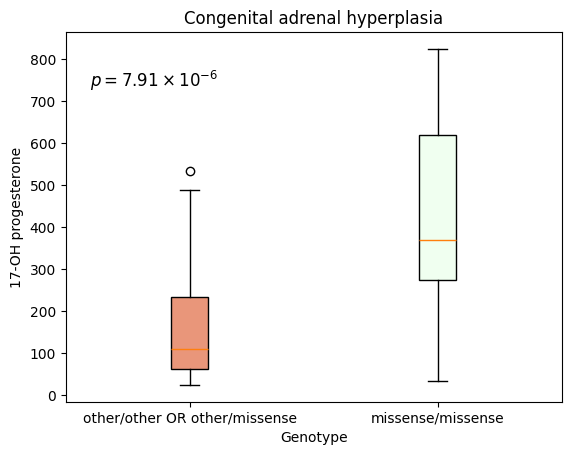

In [10]:
import matplotlib.pyplot as plt

# Create a figure and an axis
fig_17ohprog, ax = plt.subplots()
result_1_or_2_missense_17hp.plot_boxplots(ax=ax)
ax.set_xlabel('Genotype')
ax.set_ylabel('17-OH progesterone')
ax.set_title('Congenital adrenal hyperplasia')
ax.text(0.05, 0.9, r'$p = 7.91 \times 10^{-6}$', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left')
plt.savefig("cyp21a2.pdf", format="pdf")

# Summary

In [11]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


m_results = (
    GPAnalysisResultSummary.from_multi(
        result=result_1_or_2_missense_17hp
    ),
)


report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Description,Variable,Genotype (A),Genotype (B),p value
Value of 17-Hydroxyprogesterone [Mass/volume] in Serum or Plasma [LOINC:1668-3],LOINC:1668-3,other/other OR other/missense,missense/missense,7.91e-06


In [13]:
summarizer.process_latex(report=report, protein_fig=cyp21a2_fig, stats_fig=fig_17ohprog)

Figure saved to ../../supplement/img/CYP21A2_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/CYP21A2_stats-draft.pdf
Output to ../../supplement/tex/CYP21A2_summary_draft.tex
